In [1]:
import mapsims
import numpy as np
import healpy as hp
import pysm3.units as u
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt

# Access existing noise map based simulations

The last noise simulation, just released is [`202006_noise`](https://github.com/simonsobs/map_based_simulations/tree/master/202006_noise).

What is different in noise releases is that just 1 realization of full mission and splits is saved on disk, the others can be generated on-the-fly using `mapsims`, as we will see in the next notebook.

In [2]:
channels = mapsims.parse_channels("tube:ST2")

In [3]:
channel = channels[0][0]

In [4]:
print(channel)

Channel ST2_MFS1


This release has variable $N_{side}$ based on the channel, see [this table](https://github.com/simonsobs/mapsims/blob/master/mapsims/data/so_default_resolution.csv), we have a utility function to retrieve that:

In [5]:
nside = mapsims.get_default_so_resolution(channel)

# Load maps from a map based release at NERSC

In [6]:
folder = Path("/project/projectdirs/sobs/v4_sims/mbs/")
release = "202006_noise"

In [7]:
filename_template = "{content}/{num:04d}/simonsobs_{content}_uKCMB_{tube}_{band}_nside{nside}_{num:04d}_{split}_of_{nsplits}.fits"

In [8]:
filenames = [Path(folder) / release / filename_template.format(nside=nside, content="noise", num=0, 
                                                   telescope=channel.telescope, tube=channel.tube, band=channel.band,
                                                             split=1, nsplits=1)]

In [9]:
for split in range(1, 5):
    filenames += [Path(folder) / release / filename_template.format(nside=nside, content="noise", num=0, 
                                                   telescope=channel.telescope, tube=channel.tube, band=channel.band,
                                                             split=split, nsplits=4)]

In [10]:
maps = [hp.read_map(filename, (0,1,2)) for filename in filenames]

/global/common/software/sobs/mbs/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


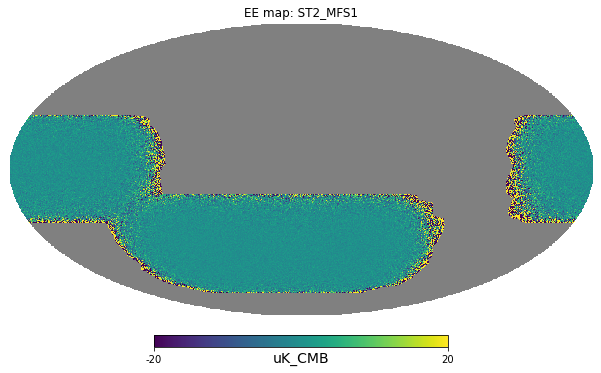

In [11]:
hp.mollview(maps[0][1], min=-20, max=20, title="EE map: " + channel.tag, unit="uK_CMB")

# Load the theoretical noise curve

Using `mapsims`, we can load the noise spectra generated from the `so_noise_models` package.
By default they are generated for the full sky, therefore we need to scale down by the sky fraction
to get the expected noise for a partial sky survey.

In [12]:
noise = mapsims.SONoiseSimulator(nside=nside)

In [13]:
ell, ps_T, ps_P = noise.get_fullsky_noise_spectra(tube=channel.tube)

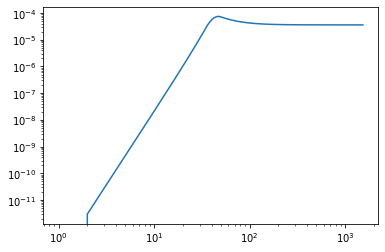

In [14]:
plt.loglog(ell, ps_P[0]);

# Load hitmaps, apodize and take spectra

Noise is very inhomogeneous, a direct anafast would be dominated by the border pixels with just a few hits, the trick is to multiply by the hitmap and then renormalize by the mean of the hitmap squared (as the $C_\ell$ are in power).

The sky fraction instead is needed because `anafast` always takes a transform of the full sky setting 0 on all the missing pixels.
Therefore the spectrum power is averaged down and we need to scale back by the sky fraction.

In [15]:
hitmaps, ave_nhits = noise.get_hitmaps(tube=channel.tube)

/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/healpix/ST2_MFS1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/healpix/ST2_MFS2_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


In [16]:
sky_fraction = (hitmaps[0] > 0).sum() / len(hitmaps[0])

In [17]:
sky_fraction

0.3847748438517253

In [18]:
# using iter=0 to speed it up, for production runs set use_pixel_weights=True
cls = [hp.anafast(m * hitmaps[0], iter=0) / np.mean(hitmaps[0]**2) / sky_fraction for m in maps]

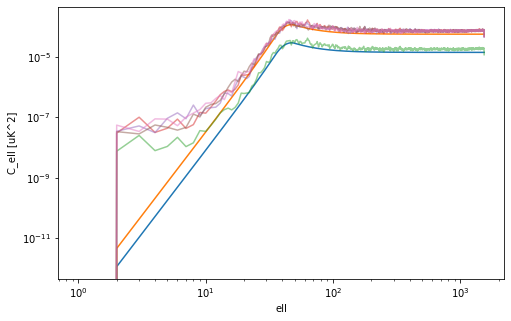

In [19]:
plt.figure(figsize=(8, 5))
plt.loglog(ell, ps_P[0] * sky_fraction)
plt.loglog(ell, ps_P[0] * sky_fraction * 4)

for cl in cls:
    plt.loglog(cl[1], alpha=.5)
plt.xlabel("ell")
plt.ylabel("C_ell [uK^2]");

# Add foregrounds and CMB

Currently the noise simulations are at variable $N_{side}$ while the foregrounds and CMB are 512/4096, so we might need to use `hp.ud_grade`. We are lucky that this channel is already at 512 so we do not need to.

The next foreground release will also be at variable $N_{side}$ so this issue will not apply anymore.

In [20]:
folder = "/project/projectdirs/sobs/v4_sims/mbs/201906_highres_foregrounds_extragalactic_tophat"

In [21]:
filename_template = "{nside}/{content}/{num:04d}/simonsobs_{content}_uKCMB_{telescope}{band}_nside{nside}_{num:04d}.fits"

In [22]:
filename = Path(folder) / filename_template.format(nside=512, content="combined", num=0, 
                                                   telescope=channel.telescope.lower(), band=channel.band)

In [23]:
foregrounds_cmb = hp.ma(hp.read_map(filename, (0,1,2)))

/global/common/software/sobs/mbs/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING


In [24]:
maps = [each + foregrounds_cmb for each in maps]

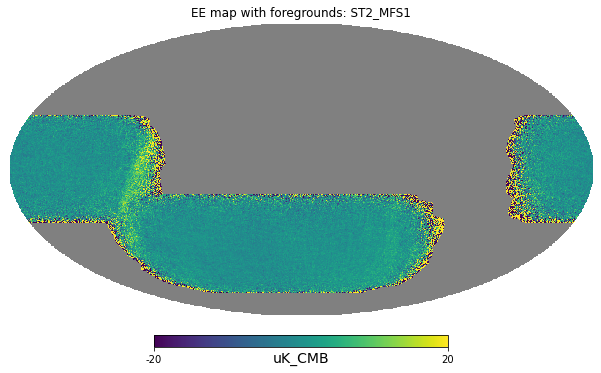

In [25]:
hp.mollview(maps[0][1], min=-20, max=20, title="EE map with foregrounds: " + channel.tag, unit="uK_CMB")